# "Auto-Encoding Variational Bayes" paper implementation - https://arxiv.org/pdf/1312.6114.pdfd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np
from matplotlib import pyplot as plt

to_tensor = transforms.ToTensor()
to_image = transforms.ToPILImage()

train_set = MNIST('./data', download=True, transform=to_tensor)
train_loader = DataLoader(train_set, shuffle=True, batch_size=128)


In [3]:
class VAE(nn.Module):

    def __init__(self, n_input=784, n_hidden=256, n_latent=2):
        super(VAE, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_latent = n_latent
        self.encoder = nn.Sequential(
            nn.Linear(self.n_input, self.n_hidden),
            nn.ReLU(),
        )
        self.z_mean = nn.Linear(self.n_hidden, self.n_latent)
        self.z_log_sigma = nn.Linear(self.n_hidden, self.n_latent)
        self.decoder = nn.Sequential(
            nn.Linear(self.n_latent, self.n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.n_input),
            nn.Sigmoid()
        )

    def sample(self, mu, log_sigma):
        sigma = torch.exp(log_sigma/2)
        epsilon = torch.rand_like(sigma)
        return mu + epsilon * sigma

    def forward(self, x):
        x = x.view(-1, self.n_input)
        x = self.encoder(x)
        mu = self.z_mean(x)
        log_sigma = self.z_log_sigma(x)
        z = self.sample(mu, log_sigma)
        y = self.decoder(z)
        return y, mu, log_sigma


In [4]:
def calculate_loss(y, x, mu, log_sigma):
    KLdiv = -0.5*(1+log_sigma-mu.pow(2)-log_sigma.exp()).sum()
    recon_loss = nn.BCELoss(reduction='sum')(y, x)
    return KLdiv + recon_loss

In [6]:
vae = VAE(784,256,2)
optimizer = optim.Adam(vae.parameters())
epochs = 40

for epoch in range(epochs):
    
    total_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(-1,784)
        optimizer.zero_grad()
        y, mu, log_sigma = vae(x)
        loss = calculate_loss(y, x, mu, log_sigma)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    
    print('Epoch: {} Loss: {}'.format(epoch, total_loss/len(train_loader.dataset)))

Epoch: 0 Loss: 193.74039010416666
Epoch: 1 Loss: 169.1861193359375
Epoch: 2 Loss: 162.56595607096355
Epoch: 3 Loss: 159.70401842447916
Epoch: 4 Loss: 157.98321376953126
Epoch: 5 Loss: 156.72295026041667
Epoch: 6 Loss: 155.72166725260416
Epoch: 7 Loss: 154.8535840657552
Epoch: 8 Loss: 154.04663349609376
Epoch: 9 Loss: 153.38298999023436
Epoch: 10 Loss: 152.74026630859376
Epoch: 11 Loss: 152.15290799153647
Epoch: 12 Loss: 151.62463012695312
Epoch: 13 Loss: 151.13477501627605
Epoch: 14 Loss: 150.65676586914063
Epoch: 15 Loss: 150.24218028971353
Epoch: 16 Loss: 149.8970829264323
Epoch: 17 Loss: 149.46100694986978
Epoch: 18 Loss: 149.12648173828126
Epoch: 19 Loss: 148.76186572265624
Epoch: 20 Loss: 148.46609280598958
Epoch: 21 Loss: 148.27468193359374
Epoch: 22 Loss: 147.98197119140625
Epoch: 23 Loss: 147.69188901367187
Epoch: 24 Loss: 147.47138709309897
Epoch: 25 Loss: 147.26601015625
Epoch: 26 Loss: 147.04617744140626
Epoch: 27 Loss: 146.84676240234376
Epoch: 28 Loss: 146.68215794270833
E

In [7]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.Tensor([[xi, yi]])
        x_decoded = vae.decoder(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

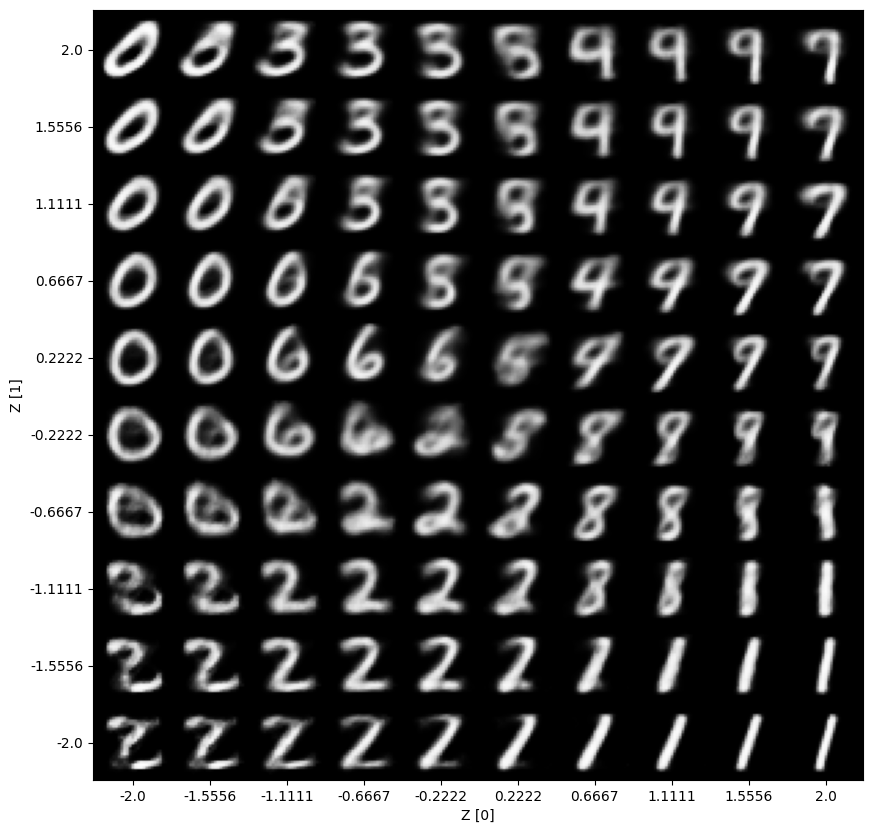

In [8]:
plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 4)
sample_range_y = np.round(grid_y, 4)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("Z [0]")
plt.ylabel("Z [1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig('fig.jpg')
plt.show()